# Datasets comparison between CAMS and IASI (L3)

## Imports and supporting functions

In [1]:
import os 
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import xarray as xr
import pandas as pd
import numpy as np
from itertools import product
import scipy.interpolate
from copy import copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import math
import geojson
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import cdist
import datetime as dt
import geocoder
import seaborn as sns
from matplotlib import animation
from IPython.display import HTML, display  
import urllib3
import warnings

In [2]:
%run functions/functions_general.ipynb
%run functions/functions_cams.ipynb
%run functions/functions_iasi.ipynb

In [3]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

# Hide API request warning
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Increase animation limit
matplotlib.rcParams['animation.embed_limit'] = 25000000

# Hide labels animation warning
warnings.filterwarnings('ignore', category = UserWarning, module='cartopy')

## 1. Define datasets

In [4]:
# Define component (CO or O3)
component_nom = 'CO'

# Define model
model = 'cams'
model_full_name = 'cams-global-reanalysis-eac4-monthly'

# Define sensor
sensor = 'iasi'
sensor_type = 'L3'
satellites = ['A', 'B', 'C']
apply_kernels = False

# Define search period
start_date = '2018-01-01'
end_date = '2021-10-01'

# Define extent
lon_min = -20
lon_max = 5
lat_min = 27
lat_max = 45

# Define resolution (Minimum: 1x1)
lat_res = 1
lon_res = 1

In [5]:
# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name, sensor_type, apply_kernels)

# Get component full name and molecular weight
component, component_mol_weight, product_type, sensor_column = components_table(sensor, component_nom, sensor_type)

# Folders generation
generate_folders(model, sensor, component_nom, sensor_type)

The comparison is possible and will start now.


In [6]:
# Generate array with search dates
dates = search_period(start_date, end_date, sensor, sensor_type)

# Create bbox
bbox = search_bbox(lon_min, lat_min, lon_max, lat_max)

SEARCH PERIOD
- In months: ('2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12', '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10')
SEARCH BOUNDING BOX
Latitudes: from 27 to 45
Longitudes: from -20 to 5


## 2. Model data

### Download and read data as xarray

In [7]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, component_nom, 
                                               model_full_name, model_level = 'Single',
                                               CAMS_UID = None, CAMS_key = None)

2021-12-15 21:50:18,149 INFO Welcome to the CDS
2021-12-15 21:50:18,150 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-reanalysis-eac4-monthly
2021-12-15 21:50:18,240 INFO Request is completed
2021-12-15 21:50:18,241 INFO Downloading https://download-0000.copernicus-atmosphere.eu/cache-compute-0000/cache/data4/adaptor.mars.internal-1639116269.1370633-24748-1-81025108-c478-41c7-bab1-5247e0450a94.grib to /home/alba/adc-toolbox/data/cams/CO/CO-monthly-tc-2018-01-01-2021-10-01.grib (13.9M)


The file does not exist, it will be downloaded.


2021-12-15 21:50:18,779 INFO Download rate 25.9M/s  


In [8]:
model_ds, dates = CAMS_read(model_product_name, component, component_nom, dates)
model_ds

<xarray.Dataset>
Dimensions:     (latitude: 25, longitude: 35, time: 42)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2018-01-01 2018-02-01 ... 2021-06-01
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 27.0 27.75 28.5 29.25 ... 43.5 44.25 45.0
  * longitude   (longitude) float64 -20.25 -19.5 -18.75 -18.0 ... 3.75 4.5 5.25
    valid_time  (time) datetime64[ns] ...
Data variables:
    component   (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-12-15T21:50 GRIB to CDM+CF via cfgrib-0.9.9...

### Collect 137 levels model data

In [9]:
model_levels_df = CAMS_137_levels()
model_levels_df

a [Pa]         b   ph [hPa]   pf [hPa]  Geopotential Altitude [m]  \
hybrid                                                                         
1        2.000365  0.000000     0.0200     0.0100                   79301.79   
2        3.102241  0.000000     0.0310     0.0255                   73721.58   
3        4.666084  0.000000     0.0467     0.0388                   71115.75   
4        6.827977  0.000000     0.0683     0.0575                   68618.43   
5        9.746966  0.000000     0.0975     0.0829                   66210.99   
...           ...       ...        ...        ...                        ...   
133     62.781250  0.988500  1002.2250  1000.5165                     106.54   
134     22.835938  0.991984  1005.3562  1003.7906                      79.04   
135      3.757813  0.995003  1008.2239  1006.7900                      53.92   
136      0.000000  0.997630  1010.8487  1009.5363                      30.96   
137      0.000000  1.000000  1013.2500  1012.0494                      10.00   

       Geometric Altitude [m] Temperature [K]  Density [kg/m^3]    ph [Pa]  \
hybrid                                                                       
1                    80301.65          198.05          0.000018       2.00   
2                    74584.91          209.21          0.000042       3.10   
3                    71918.79          214.42          0.000063       4.67   
4                    69365.77          221.32          0.000090       6.83   
5                    66906.53          228.06          0.000127       9.75   
...                       ...             ...               ...        ...   
133                    106.54          287.46          1.212498  100222.50   
134                     79.04          287.64          1.215710  100535.62   
135                     53.92          287.80          1.218650  100822.39   
136                     30.96          287.95          1.221341  101084.87   
137                     10.00          288.09          1.223803  101325.00   

        ph-diff [Pa]  Depth [m]  
hybrid                           
1               2.00    5580.21  
2               1.10    2605.83  
3               1.57    2497.32  
4               2.16    2407.44  
5               2.92    2320.96  
...              ...        ...  
133           341.69      27.50  
134           313.12      25.12  
135           286.77      22.96  
136           262.48      20.96  
137           240.13      10.00  

[137 rows x 11 columns]

### Convert CAMS data units (kg/m2 to molecules/cm<sup>2</sup>)

In [10]:
model_ds, units = model_convert_units(model, model_ds, sensor, 
                                      component_mol_weight, model_levels_df,
                                      start_date, end_date, component_nom, apply_kernels,
                                      CAMS_UID = None, CAMS_key = None)

The model component units have been converted from kg m**-2 to molec cm-2.


## 3. Sensor data

In [11]:
dates = sensor_download(sensor, sensor_type, component_nom, dates, satellites)

RESULTS
For 2018-01:
IASI_METOPA_L3_CO_COLUMN_201801_ULB-LATMOS_V20151001.0.nc was downloaded.
IASI_METOPB_L3_CO_COLUMN_201801_ULB-LATMOS_V20151001.0.nc was downloaded.
IASI_METOPC_L3_CO_COLUMN_201801_ULB-LATMOS_V20151001.0.nc is not available.
For 2018-02:
IASI_METOPA_L3_CO_COLUMN_201802_ULB-LATMOS_V20151001.0.nc was downloaded.
IASI_METOPB_L3_CO_COLUMN_201802_ULB-LATMOS_V20151001.0.nc was downloaded.
IASI_METOPC_L3_CO_COLUMN_201802_ULB-LATMOS_V20151001.0.nc is not available.
For 2018-03:
IASI_METOPA_L3_CO_COLUMN_201803_ULB-LATMOS_V20151001.0.nc was downloaded.
IASI_METOPB_L3_CO_COLUMN_201803_ULB-LATMOS_V20151001.0.nc was downloaded.
IASI_METOPC_L3_CO_COLUMN_201803_ULB-LATMOS_V20151001.0.nc is not available.
For 2018-04:
IASI_METOPA_L3_CO_COLUMN_201804_ULB-LATMOS_V20151001.0.nc was downloaded.
IASI_METOPB_L3_CO_COLUMN_201804_ULB-LATMOS_V20151001.0.nc was downloaded.
IASI_METOPC_L3_CO_COLUMN_201804_ULB-LATMOS_V20151001.0.nc is not available.
For 2018-05:
IASI_METOPA_L3_CO_COLUMN_201805

In [12]:
sensor_ds, _, _ = sensor_read(sensor, sensor_type, sensor_column, component_nom, dates, lat_res, lon_res)
sensor_ds

<xarray.Dataset>
Dimensions:         (latitude: 180, longitude: 360, time: 41)
Coordinates:
  * longitude       (longitude) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude        (latitude) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * time            (time) datetime64[ns] 2018-01-01 2018-02-01 ... 2021-06-01
Data variables:
    sensor_column   (time, longitude, latitude) float32 0.01135 0.01211 ... nan
    COgridNIGHT     (time, longitude, latitude) float32 nan nan nan ... nan nan
    ErrorgridDAY    (time, longitude, latitude) float32 0.0004834 ... nan
    ErrorgridNIGHT  (time, longitude, latitude) float32 nan nan nan ... nan nan
Attributes:
    units:    mol m-2

### Convert IASI data units (From mol/m<sup>2</sup> to molecules/cm<sup>2</sup>)

In [13]:
sensor_ds = sensor_convert_units(sensor_ds, sensor, component_nom)
sensor_ds

The sensor component units have been converted from mol cm-2 to molec cm-2.


<xarray.Dataset>
Dimensions:         (latitude: 180, longitude: 360, time: 41)
Coordinates:
  * longitude       (longitude) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude        (latitude) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * time            (time) datetime64[ns] 2018-01-01 2018-02-01 ... 2021-06-01
Data variables:
    sensor_column   (time, longitude, latitude) float64 6.837e+17 ... nan
    COgridNIGHT     (time, longitude, latitude) float64 nan nan nan ... nan nan
    ErrorgridDAY    (time, longitude, latitude) float64 2.911e+16 ... nan
    ErrorgridNIGHT  (time, longitude, latitude) float64 nan nan nan ... nan nan
Attributes:
    units:    molec cm-2

## 4. Match data

In [14]:
match_df = generate_match_df(sensor_ds, model_ds, bbox, sensor, component_nom, sensor_type, apply_kernels)
match_df

FOR MONTH: 2018-01
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2018-02
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2018-03
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2018-04
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2018-05
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2018-06
The model dataset does not contain levels data.
The model dataset will be merged with the sensor dataset by nearest neighbours.
FOR MONTH: 2018-07
The model dataset does not contain levels data.
The model dataset will be merged with the sensor da

latitude  longitude       time  sensor_column   COgridNIGHT  \
0        26.5      -20.5 2018-01-01   1.844517e+18  1.877226e+18   
1        26.5      -19.5 2018-01-01   1.833694e+18  1.868229e+18   
2        26.5      -18.5 2018-01-01   1.849556e+18  1.889200e+18   
3        26.5      -17.5 2018-01-01   1.841287e+18  1.899707e+18   
4        26.5      -16.5 2018-01-01   1.857219e+18  1.906426e+18   
..        ...        ...        ...            ...           ...   
489      44.5        0.5 2021-06-01   1.871937e+18  1.885269e+18   
490      44.5        1.5 2021-06-01   1.821693e+18  1.852558e+18   
491      44.5        2.5 2021-06-01   1.699467e+18  1.775374e+18   
492      44.5        3.5 2021-06-01   1.615620e+18  1.717121e+18   
493      44.5        4.5 2021-06-01   1.788299e+18  1.829046e+18   

     ErrorgridDAY  ErrorgridNIGHT  model_column  
0    9.923162e+15    9.556668e+15  1.708518e+18  
1    9.248448e+15    9.231454e+15  1.714019e+18  
2    8.601838e+15    8.446682e+15  1.718936e+18  
3    8.670597e+15    8.440150e+15  1.737495e+18  
4    8.726702e+15    8.269941e+15  1.744045e+18  
..            ...             ...           ...  
489  6.573914e+15    1.568635e+16  1.578264e+18  
490  5.785677e+15    1.553326e+16  1.562890e+18  
491  5.363928e+15    1.349891e+16  1.517494e+18  
492  4.823336e+15    1.164804e+16  1.474411e+18  
493  4.878244e+15    1.254315e+16  1.564993e+18  

[20254 rows x 8 columns]

## 5. Merge data and calculate difference

In [15]:
merge_df = generate_merge_df(match_df, sensor_ds, model_ds, sensor, apply_kernels)
merge_df

model_column  sensor_column    difference  \
latitude longitude time                                                    
26.5     -20.5     2018-01-01  1.708518e+18   1.844517e+18  1.359999e+17   
         -19.5     2018-01-01  1.714019e+18   1.833694e+18  1.196748e+17   
         -18.5     2018-01-01  1.718936e+18   1.849556e+18  1.306202e+17   
         -17.5     2018-01-01  1.737495e+18   1.841287e+18  1.037924e+17   
         -16.5     2018-01-01  1.744045e+18   1.857219e+18  1.131748e+17   
...                                     ...            ...           ...   
44.5      0.5      2021-06-01  1.578264e+18   1.871937e+18  2.936729e+17   
          1.5      2021-06-01  1.562890e+18   1.821693e+18  2.588032e+17   
          2.5      2021-06-01  1.517494e+18   1.699467e+18  1.819730e+17   
          3.5      2021-06-01  1.474411e+18   1.615620e+18  1.412091e+17   
          4.5      2021-06-01  1.564993e+18   1.788299e+18  2.233053e+17   

                               relative_difference  
latitude longitude time                             
26.5     -20.5     2018-01-01            -0.073732  
         -19.5     2018-01-01            -0.065264  
         -18.5     2018-01-01            -0.070622  
         -17.5     2018-01-01            -0.056369  
         -16.5     2018-01-01            -0.060938  
...                                            ...  
44.5      0.5      2021-06-01            -0.156882  
          1.5      2021-06-01            -0.142067  
          2.5      2021-06-01            -0.107077  
          3.5      2021-06-01            -0.087402  
          4.5      2021-06-01            -0.124870  

[20254 rows x 4 columns]

In [16]:
descr_statistics_table = merge_df.describe()
descr_statistics_table

model_column  sensor_column    difference  relative_difference
count  2.025400e+04   1.990000e+04  1.990000e+04         19900.000000
mean   1.661270e+18   1.873468e+18  2.121910e+17            -0.109588
std    1.594305e+17   2.201894e+17  1.146906e+17             0.054015
min    1.130164e+18   1.191008e+18 -1.985060e+17            -0.452580
25%    1.535653e+18   1.720309e+18  1.292252e+17            -0.146427
50%    1.653795e+18   1.859049e+18  2.125562e+17            -0.111888
75%    1.784620e+18   2.025471e+18  2.897632e+17            -0.073261
max    2.100942e+18   3.116509e+18  1.410469e+18             0.135419

## 6. Show comparison plots

### Select plot dates

In [17]:
plot_dates = plot_period(sensor_ds, sensor_type)

The plots will be shown for the following dates:
['2018-01' '2018-02' '2018-03' '2018-04' '2018-05' '2018-06' '2018-07'
 '2018-08' '2018-09' '2018-10' '2018-11' '2018-12' '2019-01' '2019-02'
 '2019-03' '2019-04' '2019-05' '2019-06' '2019-07' '2019-08' '2019-09'
 '2019-10' '2019-11' '2020-01' '2020-02' '2020-03' '2020-04' '2020-05'
 '2020-06' '2020-07' '2020-08' '2020-09' '2020-10' '2020-11' '2020-12'
 '2021-01' '2021-02' '2021-03' '2021-04' '2021-05' '2021-06']


### Select plot extent

In [18]:
plot_bbox = plot_extent(bbox)

The plots will be shown for the following spatial extent: 
((-20, 27), (5, 45))


### Compare CAMS and IASI total columns

In [19]:
# Choose distribution (aggregated, individual or animated)
distribution_type = 'animated'

# Choose range (original, equal or manual)
range_type = 'manual'
vmin_manual = 0
vmax_manual = 3*10**18

# Define projection and colors
projection = ccrs.PlateCarree()
color_scale =  'coolwarm'

visualize_model_vs_sensor(model, sensor, component_nom, units, merge_df, plot_dates, plot_bbox, 20, 1.05, 
                          model_type, sensor_type, range_type, distribution_type, projection,
                          color_scale, vmin_manual, vmax_manual)

2021-12-15 21:53:49,777 INFO Animation.save using <class 'matplotlib.animation.HTMLWriter'>


2021-12-15 21:54:47,518 INFO Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2021-12-15 21:54:47,527 INFO MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1800x720 -pix_fmt rgba -r 1.0 -loglevel error -i pipe: -filter_complex 'split [a][b];[a] palettegen [p];[b][p] paletteuse' -y animation.gif


## 7. Retrieve nearest values to specific latitude and longitude

model_column  \
lat_search lon_search latitude longitude time                       
40.37      -3.68      40.5     -3.5      2018-01-01  1.623483e+18   
                                         2018-02-01  1.674278e+18   
                                         2018-03-01  1.737415e+18   
                                         2018-04-01  1.724448e+18   
                                         2018-05-01  1.662099e+18   
...                                                           ...   
41.61       0.62      41.5      0.5      2021-02-01  1.777546e+18   
                                         2021-03-01  1.957233e+18   
                                         2021-04-01  1.986039e+18   
                                         2021-05-01  1.792741e+18   
                                         2021-06-01  1.588072e+18   

                                                     sensor_column  \
lat_search lon_search latitude longitude time                        
40.37      -3.68      40.5     -3.5      2018-01-01   1.678330e+18   
                                         2018-02-01   1.761316e+18   
                                         2018-03-01   1.884623e+18   
                                         2018-04-01   1.917465e+18   
                                         2018-05-01   1.922761e+18   
...                                                            ...   
41.61       0.62      41.5      0.5      2021-02-01   1.933631e+18   
                                         2021-03-01   2.186783e+18   
                                         2021-04-01   2.245903e+18   
                                         2021-05-01   2.033598e+18   
                                         2021-06-01   1.785153e+18   

                                                       difference  \
lat_search lon_search latitude longitude time                       
40.37      -3.68      40.5     -3.5      2018-01-01  5.484738e+16   
                                         2018-02-01  8.703833e+16   
                                         2018-03-01  1.472076e+17   
                                         2018-04-01  1.930168e+17   
                                         2018-05-01  2.606617e+17   
...                                                           ...   
41.61       0.62      41.5      0.5      2021-02-01  1.560851e+17   
                                         2021-03-01  2.295497e+17   
                                         2021-04-01  2.598642e+17   
                                         2021-05-01  2.408576e+17   
                                         2021-06-01  1.970809e+17   

                                                     relative_difference  
lat_search lon_search latitude longitude time                             
40.37      -3.68      40.5     -3.5      2018-01-01            -0.032680  
                                         2018-02-01            -0.049417  
                                         2018-03-01            -0.078110  
                                         2018-04-01            -0.100663  
                                         2018-05-01            -0.135566  
...                                                                  ...  
41.61       0.62      41.5      0.5      2021-02-01            -0.080721  
                                         2021-03-01            -0.104971  
                                         2021-04-01            -0.115706  
                                         2021-05-01            -0.118439  
                                         2021-06-01            -0.110400  

[123 rows x 4 columns]

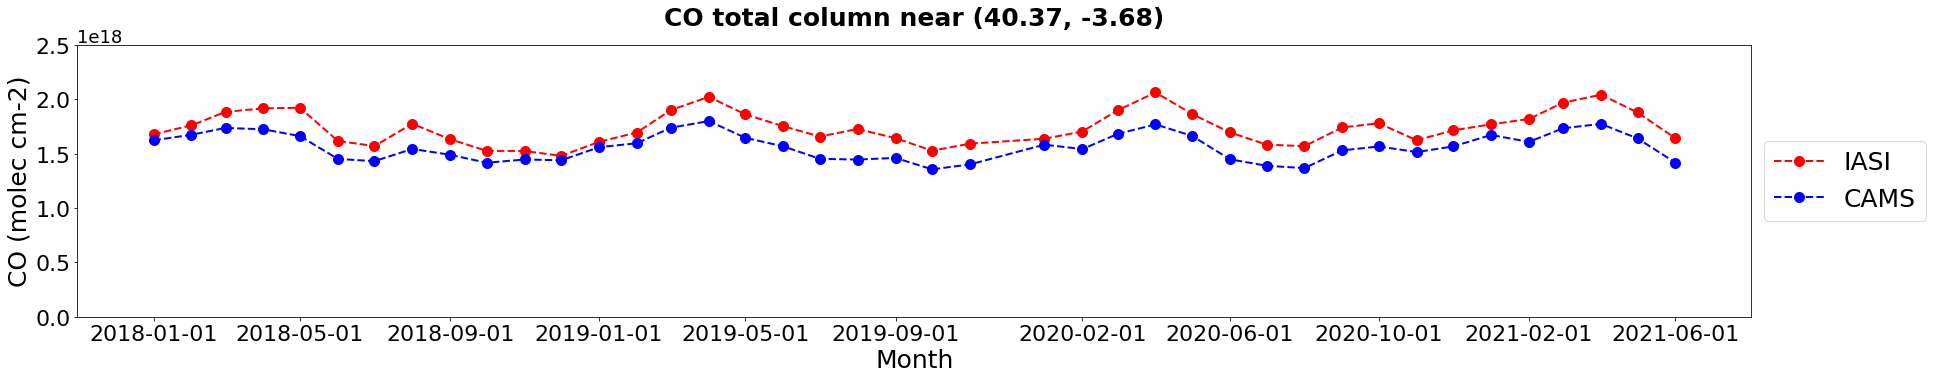

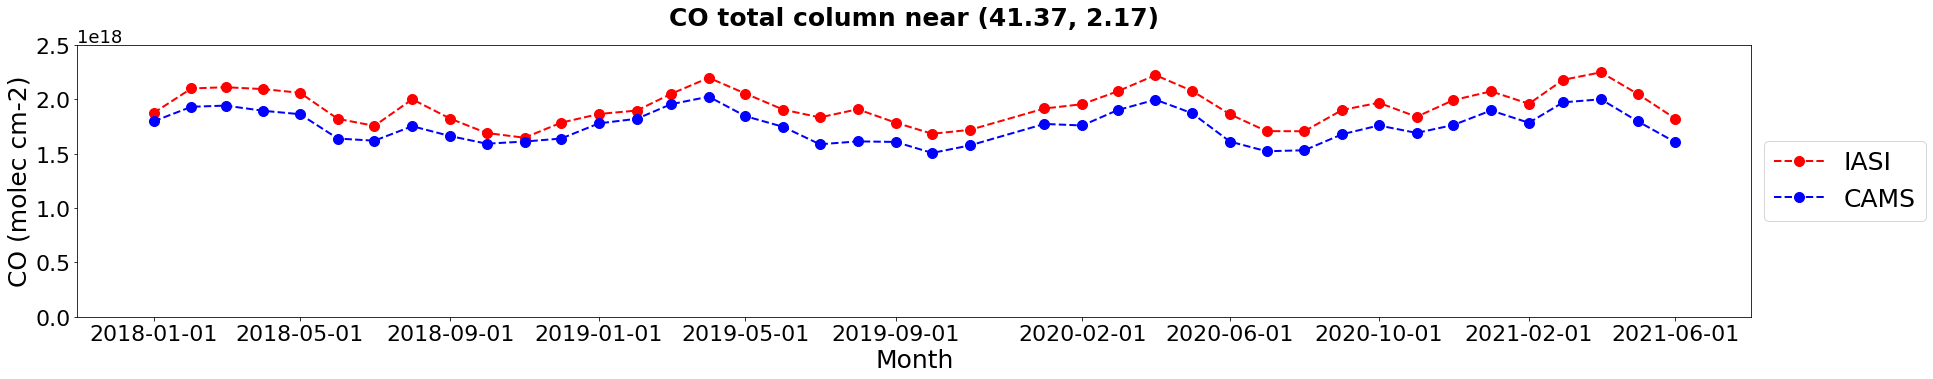

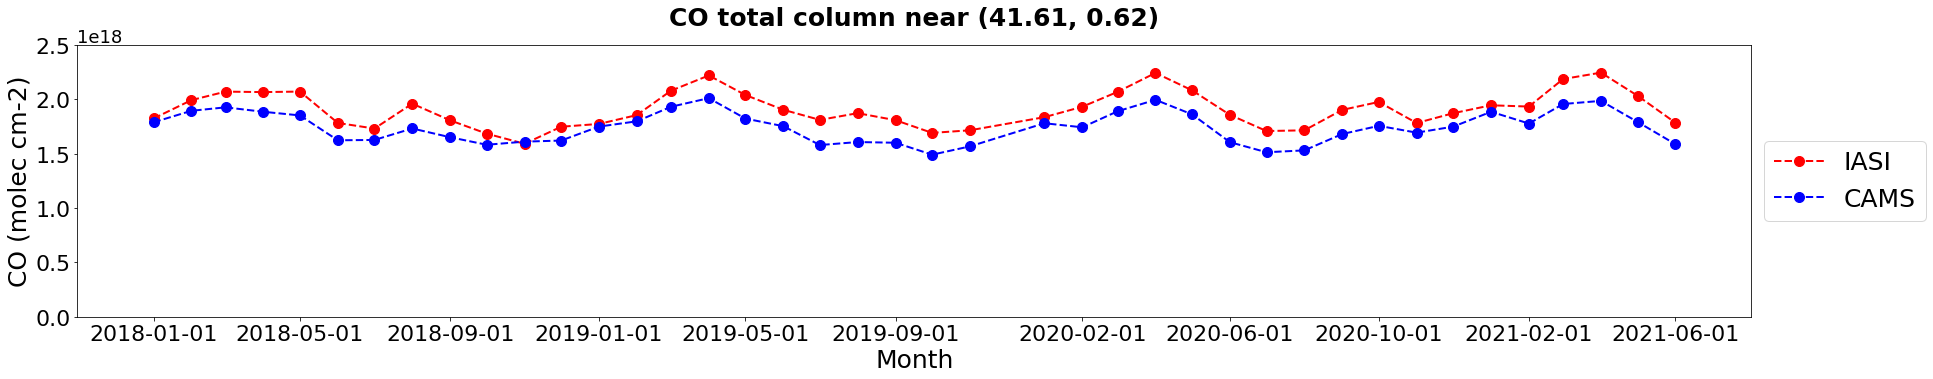

In [27]:
coords_search_list = (40.37, -3.68,
                      41.37, 2.17,
                      41.61, 0.62)
ymin = 0
ymax = 2.5*10**18
xticks = plot_dates[0::4]
retrieval_table_all = retrieve_coords(merge_df.dropna(), coords_search_list, component_nom, 
                                      sensor, model, plot_dates, units, ymin, ymax, xticks)
retrieval_table_all

## 8. Scatter plots by bbox

Fit equation: CO_model = CO_sensor * 0.63 + (4.75E+17)
Coefficient of determination (R2): 0.75


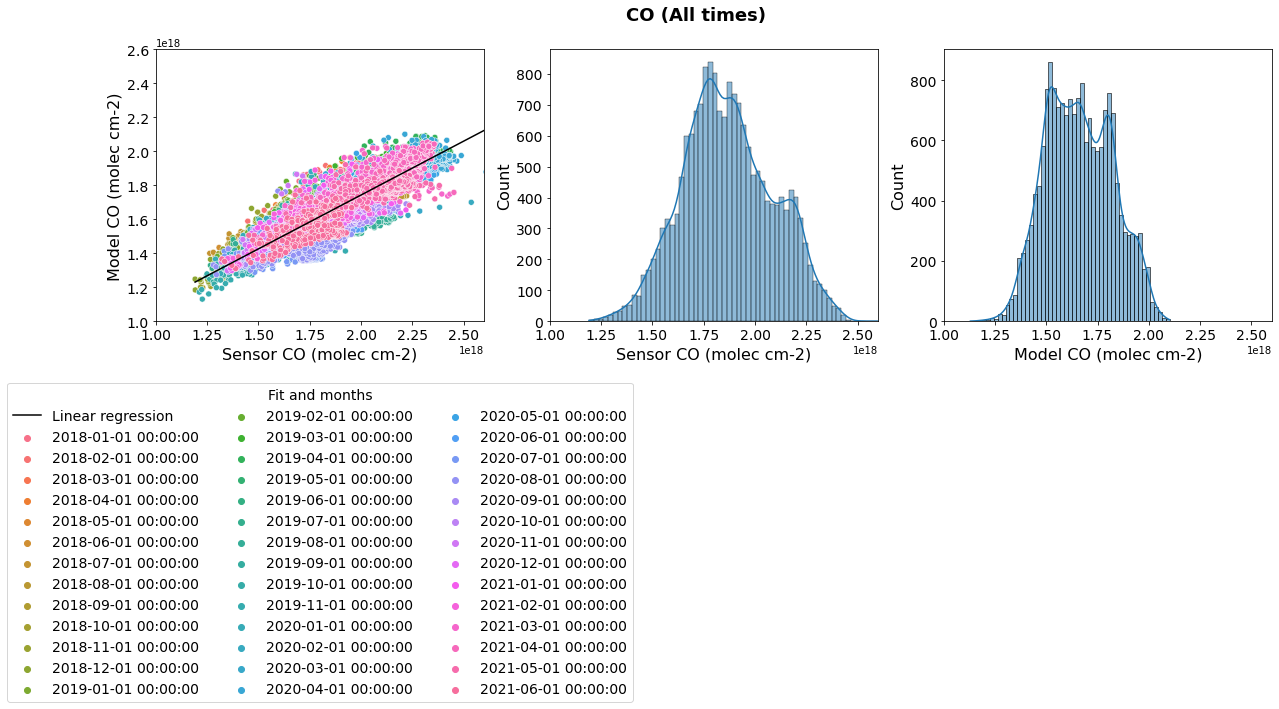

In [21]:
show_seasons = False
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual

lim_min = 1*10**18
lim_max = 2.6*10**18

summary = scatter_plot(merge_df.dropna(), component_nom, units, sensor, plot_dates, 1, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)

In [22]:
summary

Period              Location  \
0  [2018-01-01T00:00:00.000000000, 2018-02-01T00:...  ((-20, 27), (5, 45))   

      Score  Coefficient     Intercept  
0  0.752586     0.633842  4.754657e+17

## 9. Scatter plots by season

Fit equation: CO_model = CO_sensor * 0.63 + (4.75E+17)
Coefficient of determination (R2): 0.75


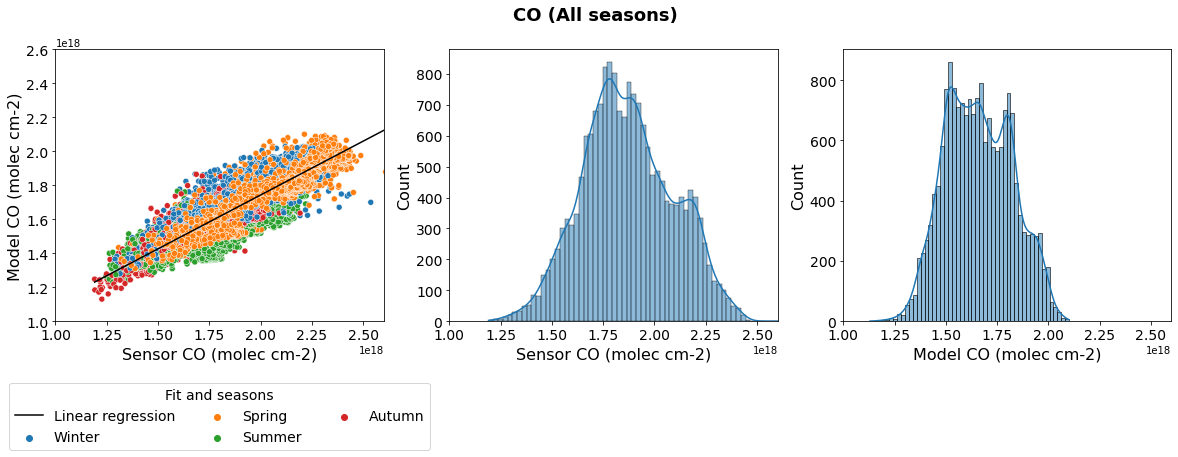

In [23]:
show_seasons = True
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual

lim_min = 1*10**18
lim_max = 2.6*10**18

summary = scatter_plot(merge_df.dropna(), component_nom, units, sensor, plot_dates, 1, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)

In [24]:
summary

Period              Location     Score  \
0  [Autumn, Spring, Summer, Winter]  ((-20, 27), (5, 45))  0.752586   

   Coefficient     Intercept  
0     0.633842  4.754657e+17

## 10. Scatter plots by country (Google API required!)

In [25]:
"""
show_seasons = False
extent_definition = 'country' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual
plot_countries = ['France', 'Germany', 'Italy']

lim_min = 1*10**18
lim_max = 2.6*10**18

summary = scatter_plot(merge_df.dropna(), component_nom, units, sensor, plot_dates, 1, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)
"""

"\nshow_seasons = False\nextent_definition = 'country' # bbox or country\nscatter_plot_type = 'individual' # aggregated or individual\nplot_countries = ['France', 'Germany', 'Italy']\n\nlim_min = 1*10**18\nlim_max = 2.6*10**18\n\nsummary = scatter_plot(merge_df.dropna(), component_nom, units, sensor, plot_dates, 1, \n                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)\n"

In [26]:
#summary